In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import VarianceThreshold
from sklearn.linear_model import LogisticRegression
from sklearn.svm import l1_min_c
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import log_loss, precision_recall_curve, average_precision_score, classification_report
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# score is not really an id, just ignored in this stage
IDS = ['device_id', 'user_id', 'mobileuid', 'subid', 'source_dfx_id', 'deviceId', 'score']
DEVICE_CAT = ['carrier_name', 'device_model', 'device_model_name', 'device_vendor']
DEVICE_NUM = ['device_os_type']
DGX_CAT = ['nameprefix', 'state', 'dwelling_type', 'professionalrollup']
DGX_NUM = ['age_range', 'income_range_vds', 'gender', 'marital_status',
           'home_ownership', 'length_of_residence', 'presence_of_children', 'home_value_range',
           'networthindicator_rollup', 'level_of_education', 'head_of_household',
           'mail_public_responder_indicator', 'mail_responsive_buyer_indicator', 'wealth_decile',
           'homeandlandvalue', 'first_mortgage_amount', 'active_fitness_interest', 'golf_interest',
           'traveler', 'green_advocate', 'premover']
RESPONSE = 'photography_interest'

In [3]:
X_train = pd.read_csv('/Users/oleg/work/segments/X_train.csv.gz', index_col='device_id', low_memory=False)
X_test = pd.read_csv('/Users/oleg/work/segments/X_test.csv.gz', index_col='device_id', low_memory=False)

In [4]:
not_app_columns = IDS + DEVICE_CAT + DEVICE_NUM + DGX_CAT + DGX_NUM + [RESPONSE]
apps = [c for c in X_train.columns if c not in not_app_columns]
print('number of apps: {}'.format(len(apps)))

number of apps: 5210


In [5]:
device_models = X_train['device_model']
X_train = pd.get_dummies(X_train, columns=['device_model'], prefix='', prefix_sep='')
X_train = pd.concat([X_train, device_models], axis=1)
device_models = device_models.unique()
print('number of device models in train set: {}'.format(len(device_models)))
device_models_test = X_test['device_model']
X_test = pd.get_dummies(X_test, columns=['device_model'], prefix='', prefix_sep='')
X_test = pd.concat([X_test, device_models_test], axis=1)

number of device models in train set: 285


In [6]:
print('number of devices in train: {}'.format(X_train.shape[0]))
print('number of devices in test: {}'.format(X_test.shape[0]))

number of devices in train: 14563
number of devices in test: 3641


In [7]:
X_train[RESPONSE].value_counts(normalize=True)

0.0    0.849619
1.0    0.150381
Name: photography_interest, dtype: float64

In [8]:
X_train.groupby('carrier_name')[RESPONSE].value_counts(normalize=True)

carrier_name  photography_interest
sprint        0.0                     0.877097
              1.0                     0.122903
verizon       0.0                     0.784273
              1.0                     0.215727
Name: photography_interest, dtype: float64

In [9]:
X_train['device_model'].value_counts(normalize=True).head(20)

sm-n950u      0.132322
sm-g955u      0.102657
sm-g965u      0.087070
sm-g930p      0.067843
sm-g950u      0.054110
sm-g960u      0.048960
sm-g935p      0.041750
sm-g920p      0.023416
moto e (4)    0.021630
moto z (2)    0.021493
lg-ls998      0.019913
pixel 2 xl    0.018471
sm-g930v      0.018059
sm-n920p      0.017716
lg-ls993      0.014626
xt1650        0.012909
sm-g935v      0.011055
lg-lk460      0.010987
sm-j327p      0.010712
lg-ls997      0.010643
Name: device_model, dtype: float64

Text(0.5,0,'users per app')

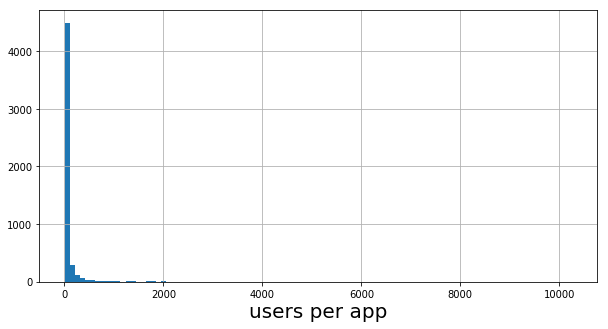

In [10]:
ax = X_train[apps].sum().hist(bins=100, figsize=(10,5))
ax.set_xlabel('users per app', fontsize=20)

In [11]:
X_train[apps].sum().describe()

count     5210.000000
mean       131.172169
std        582.154315
min          4.000000
25%         13.000000
50%         21.000000
75%         53.000000
max      10258.000000
dtype: float64

In [12]:
X_train[apps].sum().sort_values(ascending=False).head(20)

com.asurion.home.sprint                      10258
com.sprint.care                               8945
com.google.android.instantapps.supervisor     8499
com.sec.android.easymover                     7975
com.ubercab                                   7539
com.pinsight.dw                               7237
com.google.android.apps.tachyon               6761
com.google.android.apps.photos                6740
com.hyperlync.sprint.backup                   6692
com.hyperlync.sprint.cloudbinder              6649
com.pinsight.v1                               6542
com.mobolize.sprint.securewifi                6479
com.sprint.international.message              6333
com.google.android.apps.docs                  6269
com.sec.android.app.popupcalculator           6223
com.google.android.music                      6011
com.sprint.fng                                5991
com.google.android.videos                     5987
com.samsung.android.app.watchmanager          5915
com.sec.android.app.shealth    

In [13]:
def get_top_by_property(df, column, min_occurrence, top_cutoff):
    property_counts = df[column].value_counts()
    stack_apps_by_property = df.set_index(column).stack().reset_index()
    # number of devices that have an app installed, by device property and app
    property_apps = stack_apps_by_property[stack_apps_by_property[0] == 1] \
        .groupby(column)['level_1'].value_counts()
    normalized_model_app = property_apps.divide(property_counts, level=column)

    top_property_counts = \
        normalized_model_app[property_counts[property_counts > min_occurrence].index.tolist()]
    return top_property_counts[top_property_counts > top_cutoff]

In [14]:
pre_installed = {}
for property in ['carrier_name', 'device_model', 'device_vendor']:
    pre_installed_apps = get_top_by_property(X_train[[property] + apps], property, 100, 0.9)
    pre_installed[property] = pre_installed_apps
    print('{property} pre installed apps:\n{apps}'.format(
        property=property, apps=pre_installed_apps.to_string()))

carrier_name pre installed apps:
carrier_name  level_1                       
sprint        com.asurion.home.sprint           1.000000
verizon       com.asurion.solutohome.verizon    0.999072
device_model pre installed apps:
device_model  level_1                                  
lg-lk460      com.asurion.home.sprint                      1.000000
              com.hyperlync.sprint.backup                  0.943750
              com.mobolize.sprint.securewifi               0.943750
              com.sprint.fng                               0.931250
              com.hyperlync.sprint.cloudbinder             0.906250
lg-ls993      com.asurion.home.sprint                      1.000000
              com.google.android.instantapps.supervisor    0.971831
              com.sprint.w.v8                              0.920188
lg-ls997      com.asurion.home.sprint                      1.000000
              com.google.android.instantapps.supervisor    0.987097
              com.sprint.care          

device_vendor pre installed apps:
device_vendor  level_1                                  
google         com.asurion.solutohome.verizon               0.984906
               com.google.android.apps.docs.editors.docs    0.922642


Text(0.5,0,'apps per user')

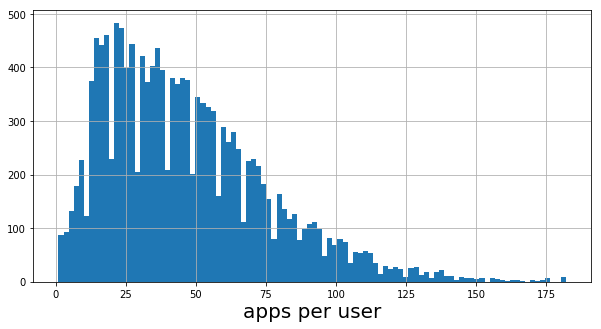

In [15]:
ax = X_train[apps].sum(axis=1).hist(bins=100, figsize=(10,5))
ax.set_xlabel('apps per user', fontsize=20)

In [16]:
X_train[apps].sum(axis=1).describe()

count    14563.000000
mean        46.927625
std         29.225959
min          1.000000
25%         24.000000
50%         42.000000
75%         63.000000
max        182.000000
dtype: float64

In [17]:
def filter_low_var_columns(df, threshold):
    low_var = VarianceThreshold(threshold=threshold).fit(df)
    return df.columns[low_var.get_support()]

In [18]:
model_df = X_train.copy()
model_df_test = X_test.copy()
for property in ['carrier_name', 'device_model', 'device_vendor']:
    for p, apps_replace in pre_installed[property].groupby(level=0):
        apps_replace_list = apps_replace.index.get_level_values('level_1').tolist()
        model_df.loc[model_df[property] == p, apps_replace_list] = 0
        model_df_test.loc[model_df_test[property] == p, apps_replace_list] = 0
filtered_models = filter_low_var_columns(model_df[device_models], 0.0099)
features = np.append(filtered_models, apps)
model_df = model_df[features]
response = X_train[RESPONSE]

Text(0.5,0,'users per app - after canceling pre installed apps')

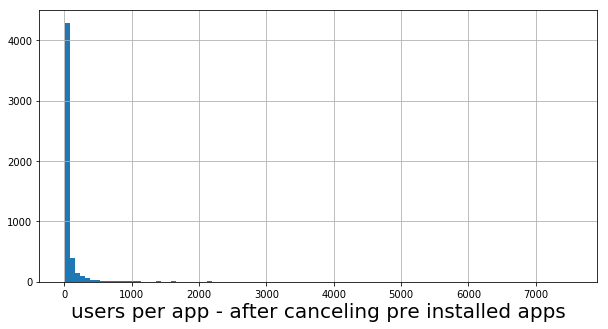

In [19]:
ax = model_df[apps].sum().hist(bins=100, figsize=(10,5))
ax.set_xlabel('users per app - after canceling pre installed apps', fontsize=20)

In [20]:
model_df[apps].sum().describe()

count    5210.000000
mean      113.577159
std       461.205017
min         4.000000
25%        13.000000
50%        21.000000
75%        53.000000
max      7539.000000
dtype: float64

In [21]:
model_df[apps].sum().sort_values(ascending=False).head(20)

com.ubercab                                  7539
com.pinsight.dw                              7122
com.sprint.care                              6810
com.pinsight.v1                              6542
com.hyperlync.sprint.backup                  6421
com.hyperlync.sprint.cloudbinder             6384
com.mobolize.sprint.securewifi               6211
com.sprint.international.message             5930
com.sprint.fng                               5618
com.pandora.android                          5449
com.google.android.play.games                5318
com.hulu.plus                                5187
com.samsung.oh                               4724
com.snapchat.android                         4682
com.netflix.mediaclient                      4667
com.nextradioapp.nextradio                   4650
com.google.android.instantapps.supervisor    4546
com.mobitv.client.sprinttvng                 4407
com.amazon.mp3                               4384
com.yahoo.mobile.client.android.mail         4375


Text(0.5,0,'apps per user - after canceling pre installed apps')

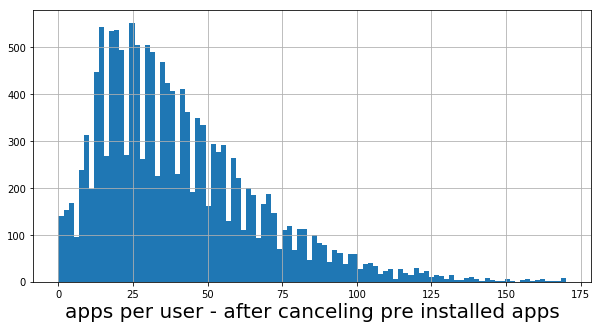

In [22]:
ax = model_df[apps].sum(axis=1).hist(bins=100, figsize=(10,5))
ax.set_xlabel('apps per user - after canceling pre installed apps', fontsize=20)

In [23]:
model_df[apps].sum(axis=1).describe()

count    14563.000000
mean        40.632905
std         26.827845
min          0.000000
25%         21.000000
50%         35.000000
75%         55.000000
max        170.000000
dtype: float64

In [24]:
print('all zero rows: {}'.format((model_df.sum(axis=1) == 0).sum()))
print('all zero columns: {}'.format((model_df.sum() == 0).sum()))

all zero rows: 21
all zero columns: 0


In [25]:
min_c = l1_min_c(model_df, response, loss='log')
tuned_parameters = {'C': np.log10(np.logspace(min_c, min_c * 5000, 50))}

In [26]:
tuned_parameters

{'C': array([1.96405774e-04, 2.02338030e-02, 4.02712003e-02, 6.03085976e-02,
        8.03459948e-02, 1.00383392e-01, 1.20420789e-01, 1.40458187e-01,
        1.60495584e-01, 1.80532981e-01, 2.00570378e-01, 2.20607776e-01,
        2.40645173e-01, 2.60682570e-01, 2.80719967e-01, 3.00757365e-01,
        3.20794762e-01, 3.40832159e-01, 3.60869557e-01, 3.80906954e-01,
        4.00944351e-01, 4.20981748e-01, 4.41019146e-01, 4.61056543e-01,
        4.81093940e-01, 5.01131337e-01, 5.21168735e-01, 5.41206132e-01,
        5.61243529e-01, 5.81280926e-01, 6.01318324e-01, 6.21355721e-01,
        6.41393118e-01, 6.61430515e-01, 6.81467913e-01, 7.01505310e-01,
        7.21542707e-01, 7.41580104e-01, 7.61617502e-01, 7.81654899e-01,
        8.01692296e-01, 8.21729694e-01, 8.41767091e-01, 8.61804488e-01,
        8.81841885e-01, 9.01879283e-01, 9.21916680e-01, 9.41954077e-01,
        9.61991474e-01, 9.82028872e-01])}

In [27]:
clf = GridSearchCV(LogisticRegression(penalty='l1', random_state=100),
                   tuned_parameters, cv=4, scoring=('neg_log_loss', 'average_precision'),
                   return_train_score=True, refit='average_precision')
clf.fit(model_df, response)

GridSearchCV(cv=4, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=100, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': array([1.96406e-04, 2.02338e-02, 4.02712e-02, 6.03086e-02, 8.03460e-02,
       1.00383e-01, 1.20421e-01, 1.40458e-01, 1.60496e-01, 1.80533e-01,
       2.00570e-01, 2.20608e-01, 2.40645e-01, 2.60683e-01, 2.80720e-01,
       3.00757e-01, 3.20795e-01, 3.40832e-01, 3.60870e-01, 3.80907e... 8.61804e-01, 8.81842e-01,
       9.01879e-01, 9.21917e-01, 9.41954e-01, 9.61991e-01, 9.82029e-01])},
       pre_dispatch='2*n_jobs', refit='average_precision',
       return_train_score=True,
       scoring=('neg_log_loss', 'average_precision'), verbose=0)

In [28]:
print('mean CV average precision: {}'.format(clf.best_score_))
print('best param: {}'.format(clf.best_params_))
print('best param index: {}'.format(clf.best_index_))
print('CV average precision: {}'.format(
    [clf.cv_results_['split0_test_average_precision'][clf.best_index_],
     clf.cv_results_['split1_test_average_precision'][clf.best_index_],
     clf.cv_results_['split2_test_average_precision'][clf.best_index_],
     clf.cv_results_['split3_test_average_precision'][clf.best_index_]]))

mean CV average precision: 0.24799924615113864
best param: {'C': 0.14045818661354356}
best param index: 7
CV average precision: [0.24557577485866164, 0.2773405753150586, 0.24165153870090206, 0.22742236650285003]


In [29]:
print('mean train score:\n{}'.format(clf.cv_results_['mean_train_average_precision']))
print('mean test score:\n{}'.format(clf.cv_results_['mean_test_average_precision']))

mean train score:
[0.1503811  0.21424371 0.23450922 0.25505355 0.27297106 0.28451333
 0.29436145 0.30435158 0.31463753 0.32506878 0.33632722 0.34794306
 0.36001391 0.37225415 0.38469275 0.39690596 0.40978011 0.42236361
 0.43444661 0.44659522 0.45868243 0.47052047 0.4820426  0.49345142
 0.50447489 0.51537043 0.52599678 0.53617096 0.54614832 0.55588018
 0.56530602 0.5745253  0.5835876  0.59231367 0.60058436 0.60863962
 0.61650619 0.62414244 0.63138596 0.63850881 0.6454788  0.65222856
 0.65875636 0.66510969 0.67124266 0.67719959 0.68305003 0.68862327
 0.69405585 0.69932826]
mean test score:
[0.1503811  0.20700846 0.21825307 0.23111424 0.24223144 0.24578023
 0.24724036 0.24799925 0.24792394 0.24730092 0.24685092 0.24569494
 0.2442353  0.24263953 0.24138487 0.24019169 0.23852647 0.23694494
 0.2352918  0.23364098 0.23227722 0.23087636 0.2297776  0.22893259
 0.22838684 0.22750636 0.22692245 0.22645877 0.22606641 0.22557221
 0.22479488 0.22380537 0.22318805 0.22260411 0.22197366 0.22140763
 0.

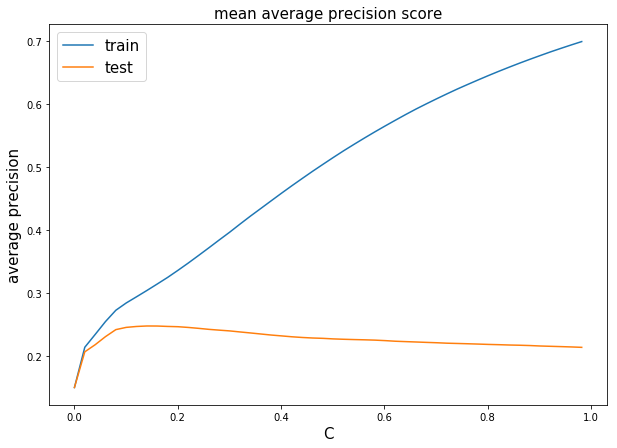

In [39]:
plt.figure(figsize=(10,7))
plt.plot(tuned_parameters['C'], clf.cv_results_['mean_train_average_precision'], label='train')
plt.plot(tuned_parameters['C'], clf.cv_results_['mean_test_average_precision'], label='test')
plt.title('mean average precision score', fontsize=15)
plt.xlabel('C', fontsize=15)
plt.ylabel('average precision', fontsize=15)
plt.legend(fontsize=15)

In [30]:
print('rank test average precision:\n{}'.format(clf.cv_results_['rank_test_average_precision']))
print('rank test log loss:\n{}'.format(clf.cv_results_['rank_test_neg_log_loss']))

rank test average precision:
[50 49 40 18 10  6  4  1  2  3  5  7  8  9 11 12 13 14 15 16 17 19 20 21
 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 41 42 43 44 45 46
 47 48]
rank test log loss:
[50 17 14 10  7  5  3  1  2  4  6  8  9 11 12 13 15 16 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49]


In [31]:
model = clf.best_estimator_
print('model iterations: {}'.format(model.n_iter_[0]))
coefs = pd.DataFrame(list(zip(model_df.columns, model.coef_[0])), columns=['app', 'coef'])

model iterations: 13


In [32]:
print('train features after regularization: {}'.format((coefs['coef'] != 0).sum()))
print('intercept: {}'.format(model.intercept_[0]))
print('coefficients:\n{}'.format(
    coefs[coefs['coef'] != 0].sort_values('coef', ascending=False).to_string(index=False)))

train features after regularization: 199
intercept: -1.596403278452229
coefficients:
app      coef
               com.adguard.android.contentblocker  0.602595
                            com.funformobile.main  0.542556
           com.passportparking.mobile.parkchicago  0.527467
        com.samsung.android.timezone.autoupdate_n  0.509739
                       com.ventrachicago.riderapp  0.498298
                                       pixel 2 xl  0.364514
                            com.intsig.camscanner  0.345598
                      com.king.candycrushsodasaga  0.274708
                       com.vzw.hs.android.modlite  0.253292
                                   com.samsung.oh  0.248469
                     org.zwanoo.android.speedtest  0.222087
                               com.adobe.psmobile  0.221305
                        com.aaa.android.discounts  0.209171
                                com.cmplay.tiles2  0.205351
com.sec.android.app.camera.shootingmode.rearca...  0.202746
 

In [33]:
print('train average precision: {}'.format(
    average_precision_score(response, model.predict_proba(model_df)[:, 1])))
print('test average precision: {}'.format(
    average_precision_score(X_test[RESPONSE], model.predict_proba(model_df_test[model_df.columns])[:, 1])))

train average precision: 0.3064920542666837
test average precision: 0.22880580845235723


In [34]:
pred_train = pd.DataFrame(list(zip(response, model.predict_proba(model_df)[:, 1])), columns=['label', 'pred'])
pred_quamtiles_train = pred_train['pred'].quantile(np.arange(0, 101, 5) / 100)
pred_vs_label_train = []
for i in range(pred_quamtiles_train.shape[0] - 1):
    pred_vs_label_train.append(pred_train.query('{low} < pred <= {high}'.format(
        low=pred_quamtiles_train.iloc[i], high=pred_quamtiles_train.iloc[i+1])).mean().tolist())
    
pred_test = pd.DataFrame(list(zip(X_test[RESPONSE], model.predict_proba(model_df_test[model_df.columns])[:, 1])), columns=['label', 'pred'])
pred_quamtiles_test = pred_test['pred'].quantile(np.arange(0, 101, 5) / 100)
pred_vs_label_test = []
for i in range(pred_quamtiles_test.shape[0] - 1):
    pred_vs_label_test.append(pred_test.query('{low} < pred <= {high}'.format(
        low=pred_quamtiles_test.iloc[i], high=pred_quamtiles_test.iloc[i+1])).mean().tolist())

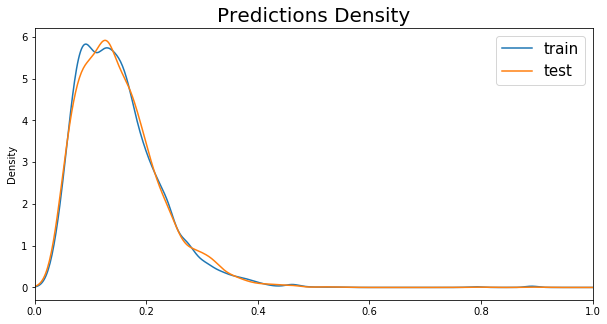

In [35]:
pred_train['pred'].plot.kde(xlim=(0, 1), figsize=(10,5), label='train')
pred_test['pred'].plot.kde(xlim=(0, 1), figsize=(10,5), label='test')
plt.title('Predictions Density', fontsize=20)
plt.legend(fontsize=15)

Text(0.5,1,'Test Data')

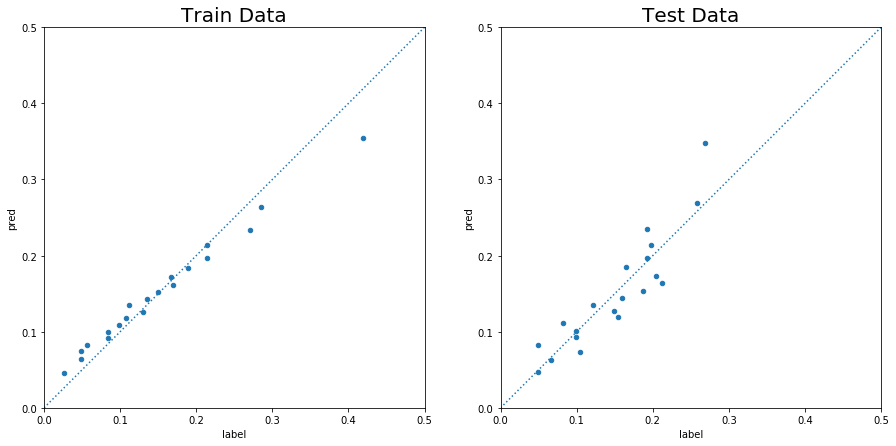

In [36]:
fig, (left, right) = plt.subplots(ncols=2, figsize=(15, 7))

pred_vs_label_train = pd.DataFrame(pred_vs_label_train, columns=['label', 'pred'])
pred_vs_label_train.plot.scatter(x='label', y='pred', xlim=(0, 0.5), ylim=(0, 0.5), ax=left)
left.plot(np.linspace(0, 0.5, 100), np.linspace(0, 0.5, 100), linestyle=':')
left.set_title('Train Data', fontsize=20)

pred_vs_label_test = pd.DataFrame(pred_vs_label_test, columns=['label', 'pred'])
pred_vs_label_test.plot.scatter(x='label', y='pred', xlim=(0, 0.5), ylim=(0, 0.5), ax=right)
right.plot(np.linspace(0, 0.5, 100), np.linspace(0, 0.5, 100), linestyle=':')
right.set_title('Test Data', fontsize=20)

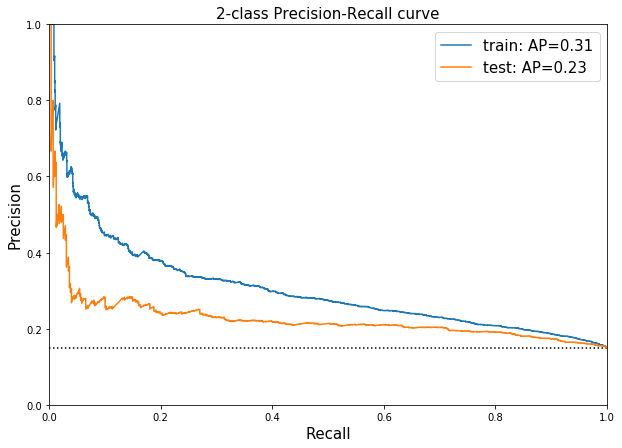

In [37]:
plt.figure(figsize=(10,7))
plt.xlim(0,1)
plt.ylim(0,1)
precision_train, recall_train, thresholds_train = \
    precision_recall_curve(pred_train['label'], pred_train['pred'])
ap_train = average_precision_score(pred_train['label'], pred_train['pred'])
plt.plot(recall_train, precision_train, label='train: AP={0:0.2f}'.format(ap_train))
precision_test, recall_test, thresholds_test = \
    precision_recall_curve(pred_test['label'], pred_test['pred'])
ap_test = average_precision_score(pred_test['label'], pred_test['pred'])
plt.plot(recall_test, precision_test, label='test: AP={0:0.2f}'.format(ap_test))
plt.hlines(response.value_counts(normalize=True).loc[1], 0, 1, linestyle=':')
plt.title('2-class Precision-Recall curve', fontsize=15)
plt.xlabel('Recall', fontsize=15)
plt.ylabel('Precision', fontsize=15)
plt.legend(fontsize=15)

In [38]:
f1_score = 2 * recall_train * precision_train / (recall_train + precision_train)
f1_score_max_idx = np.where(f1_score == f1_score.max())[0][0]
optial_cutoff = thresholds_train[f1_score_max_idx]
print('optial cutoff: {}'.format(optial_cutoff))
print('\ntrain:')
print(classification_report(pred_train['label'], pred_train['pred'] > optial_cutoff))
print('\ntest:')
print(classification_report(pred_test['label'], pred_test['pred'] > optial_cutoff))

optial cutoff: 0.16951231915882184

train:
             precision    recall  f1-score   support

        0.0       0.90      0.71      0.79     12373
        1.0       0.26      0.57      0.36      2190

avg / total       0.81      0.69      0.73     14563


test:
             precision    recall  f1-score   support

        0.0       0.88      0.68      0.77      3093
        1.0       0.21      0.48      0.29       548

avg / total       0.78      0.65      0.70      3641

